In [ ]:
import datetime
def print_time():
    print("Current time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
from pyspark.sql import SparkSession
import numpy as np
import os, sys
# $example on$
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import desc, asc, col, count, when, isnan
from pyspark.sql.types import DoubleType, FloatType
from pyspark.ml.feature import StringIndexer

# $example off$
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession\
    .builder\
    .appName("ALSExample")\
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "100m") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .master("local[8]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
spark.sparkContext.setCheckpointDir("/home/rajde/spark-checkpoints") # Use an absolute path

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/05 23:15:58 WARN Utils: Your hostname, belvita, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/05 23:15:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/05 23:15:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


env PYSPARK_PYTHON: /home/rajde/miniforge3/envs/py312/bin/python
spark.conf pyspark.python: <not set>
sparkContext.pythonVer: 3.12


In [3]:
# Updated path for Spark 3.4 / 4.x
blas_instance = spark._jvm.dev.ludovic.netlib.blas.BLAS.getInstance()
print(f"Current BLAS Implementation: {blas_instance.getClass().getName()}")

Current BLAS Implementation: dev.ludovic.netlib.blas.VectorBLAS


In [ ]:
# select DISTINCT datestamp, order_id, order_value, item_id, item_brand, item_price, item_quantity,
# from surf_events
# where source_id = '23191'
# and toDate(datestamp) >= toDate(now() - INaTERVAL 1 MONTH)
# and commerce_interaction = 'purchase';
# Field	Description
# datestamp	Timestamp when the event occurred (e.g., purchase, page view)
# order_id	Unique identifier for the order transaction
# order_value	Total monetary value of the order
# item_id	Unique identifier for the product/item
# item_brand	Brand name of the product
# item_price	Unit price of the item at time of purchase
# item_quantity	Number of units purchased in the order
# user_ipaddress	IP address of the user's device
# network_userid	Persistent identifier set by the tracking library (cross-device)
# domain_userid	User identifier specific to the website domain (first-party cookie)
# domain_sessionid	Unique identifier for the user's session on the domain
# domain_sessionidx	Incrementing index of sessions for this user (1st, 2nd, 3rd session, etc.)
# geo_region	Geographic region/state of the user's location
# geo_city	City of the user's location
# geo_zipcode	ZIP/postal code of the user's location
# dvce_ismobile	Binary flag indicating if the device is mobile (1) or desktop (0)
# useragent	Browser/device user agent string containing device and browser information

In [4]:
surf_events = spark.read.csv('surfside-eng-ml-take-home-6-recommender.csv', header=True, inferSchema=True)
surf_events.printSchema()

root
 |-- datestamp: timestamp (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- order_value: double (nullable = true)
 |-- item_id: string (nullable = true)
 |-- item_brand: string (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_quantity: integer (nullable = true)
 |-- user_ipaddress: string (nullable = true)
 |-- network_userid: string (nullable = true)
 |-- domain_userid: string (nullable = true)
 |-- domain_sessionid: string (nullable = true)
 |-- domain_sessionidx: integer (nullable = true)
 |-- geo_region: string (nullable = true)
 |-- geo_city: string (nullable = true)
 |-- geo_zipcode: string (nullable = true)
 |-- dvce_ismobile: integer (nullable = true)
 |-- useragent: string (nullable = true)



In [6]:
surf_events.select("item_id").distinct().count(), surf_events.select("item_brand").distinct().count()

(64068, 495)

In [ ]:
spark.stop

In [4]:
null_counts = surf_events.select([
    count(when(
        col(c).isNull() | 
        (col(c).cast("double").isNotNull() & isnan(col(c).cast("double")) if isinstance(surf_events.schema[c].dataType, (DoubleType, FloatType)) else False), 
        c
    )).alias(c)
    for c in surf_events.columns
])

null_counts.show()

+---------+--------+-----------+-------+----------+----------+-------------+--------------+--------------+-------------+----------------+-----------------+----------+--------+-----------+-------------+---------+
|datestamp|order_id|order_value|item_id|item_brand|item_price|item_quantity|user_ipaddress|network_userid|domain_userid|domain_sessionid|domain_sessionidx|geo_region|geo_city|geo_zipcode|dvce_ismobile|useragent|
+---------+--------+-----------+-------+----------+----------+-------------+--------------+--------------+-------------+----------------+-----------------+----------+--------+-----------+-------------+---------+
|        0|      23|         25|     25|       177|        25|           25|             0|             0|            0|               0|                0|      3973|   20601|      20631|            0|        0|
+---------+--------+-----------+-------+----------+----------+-------------+--------------+--------------+-------------+----------------+---------------

In [5]:
surf_events = surf_events.dropna(subset=["network_userid", "item_id"])
indexer_ = StringIndexer(inputCols=["item_id", "network_userid"], outputCols=["item_idx", "network_useridx"])
indexer = indexer_.fit(surf_events)
surf_events = indexer.transform(surf_events)
ratings = surf_events.select(col("network_useridx"),
                              col("item_idx"),
                              col("item_quantity")).repartition(10)
(training, test) = ratings.randomSplit([0.8, 0.2])

In [6]:
ratings.show(5)

+---------------+--------+-------------+
|network_useridx|item_idx|item_quantity|
+---------------+--------+-------------+
|        39659.0|   213.0|            1|
|          106.0|   269.0|            3|
|        47989.0| 14440.0|            1|
|        12852.0| 32201.0|            1|
|        14579.0| 28436.0|            2|
+---------------+--------+-------------+
only showing top 5 rows


In [8]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=50, regParam=0.01, userCol="network_useridx", itemCol="item_idx", ratingCol="item_quantity",rank=5,
            nonnegative=True, coldStartStrategy="drop", checkpointInterval=2) # Tells ALS to use the directory every 2 iterations
print_time()
model = als.fit(training)
print_time()
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="item_quantity",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Current time: 2026-02-05 14:19:29


Current time: 2026-02-05 14:20:54


Root-mean-square error = 1.081926606593601


In [9]:
item_qs = predictions.select("item_quantity").distinct().sort("item_quantity").toPandas()["item_quantity"].unique().tolist()

In [14]:
rmses = []
counts = []
for item_q in item_qs:
    predictions_q = predictions.filter(col("item_quantity") == item_q)
    rmse_top = evaluator.evaluate(predictions_q)
    rmses.append(rmse_top)
    count = predictions_q.count()
    counts.append(np.log(count + 1))  # Adding 1 to avoid log(0)
    print(f"Root-mean-square error for top {item_q} items = {rmse_top} for {count} records")

Root-mean-square error for top 1 items = 0.5532865695666707 for 106308 records


Root-mean-square error for top 2 items = 0.9541741915615792 for 20756 records


Root-mean-square error for top 3 items = 1.4367443550740457 for 5716 records


Root-mean-square error for top 4 items = 1.8870503796598563 for 2705 records


Root-mean-square error for top 5 items = 2.566375054706778 for 1123 records


Root-mean-square error for top 6 items = 3.029311841686634 for 1668 records


Root-mean-square error for top 7 items = 3.722234107079163 for 143 records


Root-mean-square error for top 8 items = 4.284603531140495 for 382 records


Root-mean-square error for top 9 items = 5.508252498124819 for 87 records


Root-mean-square error for top 10 items = 5.0981059074297175 for 349 records


Root-mean-square error for top 11 items = 5.5199360267248005 for 14 records


Root-mean-square error for top 12 items = 6.681088606356524 for 367 records


Root-mean-square error for top 13 items = 8.07716742379029 for 7 records


Root-mean-square error for top 14 items = 8.905189803405301 for 8 records


Root-mean-square error for top 15 items = 8.614013564023951 for 80 records


Root-mean-square error for top 16 items = 9.960986994218523 for 22 records


Root-mean-square error for top 17 items = 7.917795745356709 for 6 records


Root-mean-square error for top 18 items = 9.84802338166367 for 16 records


Root-mean-square error for top 19 items = 7.490604461013359 for 4 records


Root-mean-square error for top 20 items = 11.501975573145849 for 32 records


Root-mean-square error for top 23 items = 11.458089828491211 for 1 records


Root-mean-square error for top 24 items = 14.61936013588513 for 52 records


Root-mean-square error for top 25 items = 14.930312884599 for 17 records


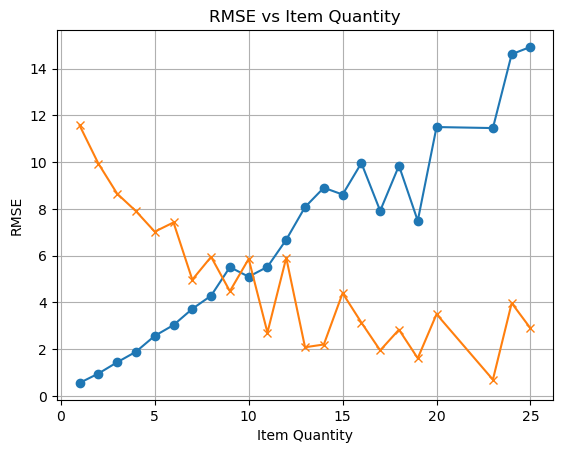

In [15]:
import matplotlib.pyplot as plt
plt.plot(item_qs, rmses, marker='o')
plt.plot(item_qs, counts, marker='x', label='Log Count')
plt.xlabel('Item Quantity')
plt.ylabel('RMSE')
plt.title('RMSE vs Item Quantity')
plt.grid()
plt.show()


In [10]:
item_subset = test.where(test.item_idx == 2)
model.recommendForItemSubset(item_subset, 5).show(truncate=False)

+--------+----------------------------------------------------------------------------------------------------+
|item_idx|recommendations                                                                                     |
+--------+----------------------------------------------------------------------------------------------------+
|2       |[{62056, 10.440798}, {58233, 10.440798}, {128281, 10.053089}, {180869, 9.919725}, {41422, 9.432343}]|
+--------+----------------------------------------------------------------------------------------------------+



In [11]:
training.where(col("network_useridx") == 2).sort(desc("item_quantity")).show()

+---------------+--------+-------------+
|network_useridx|item_idx|item_quantity|
+---------------+--------+-------------+
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|   590.0|            2|
|            2.0|    76.0|            1|
|            2.0|    76.0|            1|
|            2.0|    95.0|            1|
|            2.0|    76.0|            1|
|            2.0|   111.0|            1|
|            2.0|    76.0|            1|
|            2.0|   130.0|            1|
+---------------+--------+-------------+
only showing top

In [ ]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [93]:
def get_complementary_recommendations(basket_items, model, indexer, top_n=5):
    """
    Takes a basket of items and returns recommended complementary items.
    
    Args:
        basket_items: List of item_id strings (e.g., ["item_1", "item_2"])
        model: Trained ALS model
        indexer: Fitted StringIndexer for item_id
        top_n: Number of recommendations to return per basket item
    
    Returns:
        DataFrame with recommended complementary items
    """
    from pyspark.sql.functions import col, explode, row_number
    from pyspark.sql.window import Window
    
    # Create DataFrame from basket items
    basket_df = spark.createDataFrame([(item,) for item in basket_items], ["item_id"])
    
    # Encode basket items using the same indexer
    basket_indexed = indexer.transform(basket_df)
    basket_indices = basket_indexed.select("item_idx").rdd.map(lambda x: x[0]).collect()
    
    # Get recommendations for each item in basket
    item_subset = basket_indexed.select("item_idx").distinct()
    recommendations = model.recommendForItemSubset(item_subset, top_n)
    
    # Flatten recommendations and filter out items already in basket
    recs_exploded = recommendations.select(
        col("item_idx"),
        explode(col("recommendations")).alias("rec")
    ).select(
        col("item_idx"),
        col("rec.item_idx").alias("recommended_item_idx"),
        col("rec.item_quantity").alias("confidence_score")
    ).filter(~col("recommended_item_idx").isin(basket_indices))
    
    # Map indices back to original item_id
    # Create reverse mapping    
    recs_with_items = recs_exploded.join(
        surf_events.select("item_id", "item_idx").distinct().alias("all_items_indexed"),
        recs_exploded.recommended_item_idx == all_items_indexed.item_idx
    ).select("item_id", "confidence_score")
    
    return recs_with_items.distinct().orderBy(col("confidence_score").desc())




In [96]:
surf_events.show(5, truncate=False)

+-------------------+---------+-----------+------------------------+----------+----------+-------------+--------------+------------------------------------+------------------------------------+------------------------------------+-----------------+----------+-----------+-----------+-------------+---------------------------------------------------------------------------------------------------------------------------------------+--------+---------------+
|datestamp          |order_id |order_value|item_id                 |item_brand|item_price|item_quantity|user_ipaddress|network_userid                      |domain_userid                       |domain_sessionid                    |domain_sessionidx|geo_region|geo_city   |geo_zipcode|dvce_ismobile|useragent                                                                                                                              |item_idx|network_useridx|
+-------------------+---------+-----------+------------------------+----------+---

26/02/04 21:38:59 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


In [97]:
# Example usage:
basket = ["item678629d50c3e843442e674ae_1", "68952cf7fd2d7f6215293db1"]  # Replace with actual item IDs from your data
complementary_items = get_complementary_recommendations(basket, model, indexer, top_n=5)
complementary_items.show(10, truncate=False)

AttributeError: 'StringIndexer' object has no attribute 'transform'

In [16]:
spark.stop()

In [ ]:

# # 1. StringIndexer: Convert strings to numeric indices
# indexer = StringIndexer(inputCol="category_col", outputCol="category_index")

# # 2. OneHotEncoder: Convert indices to vectors
# encoder = OneHotEncoder(inputCol="category_index", outputCol="category_vec")

# # Use a Pipeline to run them in order
# pipeline = Pipeline(stages=[indexer, encoder])
# model = pipeline.fit(df)
# encoded_df = model.transform(df)

# encoded_df.show()

222799

# GRAVEYARD

In [7]:
import datetime
import numpy as np
def print_time():
    print("Current time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [9]:
from pyspark.sql import SparkSession
import os, sys
# $example on$
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
# $example off$
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession\
    .builder\
    .appName("ALSExample")\
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .master("local[8]") \
    .getOrCreate()

# verification
print("env PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))
print("spark.conf pyspark.python:", spark.conf.get("spark.pyspark.python","<not set>"))
print("sparkContext.pythonVer:", spark.sparkContext.pythonVer)

env PYSPARK_PYTHON: /home/rajde/miniforge3/envs/py312/bin/python
spark.conf pyspark.python: <not set>
sparkContext.pythonVer: 3.12


In [10]:
# $example on$
lines = spark.read.text("/workspace/data/sample_movielens_ratings.txt").rdd
parts = lines.map(lambda row: row.value.split("::"))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                        rating=float(p[2]), timestamp=int(p[3])))
ratings = spark.createDataFrame(ratingsRDD).repartition(10)
(training, test) = ratings.randomSplit([0.8, 0.2])
print("training:", training.count(), "test:", test.count())


training: 1214 test: 287


In [11]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|    15|     35|   2.0|1424380312|
|     4|     11|   1.0|1424380312|
|     0|     50|   1.0|1424380312|
|    29|     93|   1.0|1424380312|
|    22|     63|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows



In [14]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=20, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
            coldStartStrategy="drop")
model = als.fit(training)
print_time()
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

print_time()


Current time: 2026-02-10 22:00:09
Root-mean-square error = 1.5549688905424415
Current time: 2026-02-10 22:00:10


In [15]:
# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)
# $example off$
userRecs.show()
movieRecs.show()
userSubsetRecs.show()
movieSubSetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     0|[{90, 4.5559554},...|
|    10|[{40, 3.832136}, ...|
|    20|[{22, 4.674407}, ...|
|     1|[{94, 4.12474}, {...|
|    11|[{46, 5.3173857},...|
|    21|[{29, 4.784526}, ...|
|    22|[{51, 4.9348946},...|
|     2|[{46, 8.144104}, ...|
|    12|[{27, 5.0440946},...|
|     3|[{51, 4.8796067},...|
|    23|[{49, 5.178897}, ...|
|    13|[{93, 3.8567603},...|
|     4|[{74, 4.4193654},...|
|    24|[{96, 4.908345}, ...|
|    14|[{52, 5.1443467},...|
|    25|[{83, 4.289503}, ...|
|     5|[{55, 4.944382}, ...|
|    15|[{83, 5.764918}, ...|
|     6|[{62, 5.1518345},...|
|    16|[{85, 4.9616923},...|
+------+--------------------+
only showing top 20 rows

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     60|[{26, 3.1306605},...|
|     90|[{24, 4.9002376},...|
|      0|[{28, 2.995725}, ...|
|     30|[{11, 4.9535832},...|
|     80|[{26, 4.6932607},...|
|     

In [16]:
userSubsetRecs.show(5, truncate=200)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|                                                                                                                                                         recommendations|
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     4|[{74, 4.4193654}, {92, 4.283398}, {41, 3.9676654}, {70, 3.8877966}, {62, 3.6340203}, {29, 3.4439366}, {53, 3.2118137}, {95, 3.0730429}, {25, 3.030734}, {77, 3.0305874}]|
|    16|   [{85, 4.9616923}, {51, 4.850683}, {54, 4.7522764}, {76, 4.628806}, {29, 3.782923}, {39, 3.7441795}, {75, 3.668519}, {32, 3.6278844}, {18, 3.545703}, {66, 3.4596891}]|
|    26|  [{51, 6.636032}, {77, 5.6815906}, {88, 4.9979696}, {7, 4.9515734}, {94, 4.917775}, {24, 4.9051714}, 

In [17]:
spark.stop()